In [1]:
import numpy as np  
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy, chi2_contingency, norm, ttest_1samp
import scipy.spatial.distance as distance
import statsmodels.stats.multitest as multitest
from folktables import ACSDataSource
import statsmodels.api as sm



In [24]:
#Create sample hiring data

def hiring_data(shift, n=10000,d=0.09):
    
    np.random.seed(36)
    
    U = np.random.normal(0, 1, n)
    X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
    W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
    Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)
    sample_1 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})

    if shift == 1:
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(6/25)*(X+Z)+(1/4)*W+0.02,n)
        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    else:       
        U = np.random.normal(0, 1, n)
        X = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        Z = np.random.binomial(1,np.exp(U)/(1+np.exp(U)),n)
        W = np.random.binomial(1,0.3*(X+Z) + 0.1,n)
        Y = np.random.binomial(1,(1/5)*(X+Z)+(1/4)*W+0.02,n)

        sample_2 = pd.DataFrame({'X':X, 'Z':Z, 'W':W, 'Y':Y})
    
    return sample_1, sample_2

sample_1, sample_2 = hiring_data(0)
_ , sample_3 = hiring_data(1)

In [25]:
#compute conditionals of Y=1 on X,Z,W for all samples
y_conditional_on_xzw_sample_1 = sample_1.groupby(['X','Z','W'])['Y'].mean().reset_index()
y_conditional_on_xzw_sample_2 = sample_2.groupby(['X','Z','W'])['Y'].mean().reset_index()
y_conditional_on_xzw_sample_3 = sample_3.groupby(['X','Z','W'])['Y'].mean().reset_index()

#compare difference in conditionals
#between sample 1 vs sample 2
y_conditional_difference_sample_1_sample_2 = y_conditional_on_xzw_sample_1.merge(y_conditional_on_xzw_sample_2, on=['X','Z','W'], suffixes=('_s1','_s2'))
y_conditional_difference_sample_1_sample_2['Difference'] = y_conditional_difference_sample_1_sample_2['Y_s1'] - y_conditional_difference_sample_1_sample_2['Y_s2']
#between sample 1 vs sample 3
y_conditional_difference_sample_1_sample_3 = y_conditional_on_xzw_sample_1.merge(y_conditional_on_xzw_sample_3, on=['X','Z','W'], suffixes=('_s1','_s3'))
y_conditional_difference_sample_1_sample_3['Difference'] = y_conditional_difference_sample_1_sample_3['Y_s1'] - y_conditional_difference_sample_1_sample_3['Y_s3']

#Store the conditional probabilities as index
index = ['P(Y=1|X=0,Z=0,W=0)', 'P(Y=1|X=0,Z=0,W=1)', 'P(Y=1|X=0,Z=1,W=0)', 'P(Y=1|X=0,Z=1,W=1)', 'P(Y=1|X=1,Z=0,W=0)', 'P(Y=1|X=1,Z=0,W=1)', 'P(Y=1|X=1,Z=1,W=0)', 'P(Y=1|X=1,Z=1,W=1)']

print(f"Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 2 and their difference:\n\n{np.round(y_conditional_difference_sample_1_sample_2,4)}\n")
print(f"The average difference between sample 1 and sample 2 is {np.round(y_conditional_difference_sample_1_sample_2['Difference'].mean(),4)}\n")
print(f"Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 3 and their difference:\n\n{np.round(y_conditional_difference_sample_1_sample_3,4)}\n")
print(f"The average difference between sample 1 and sample 3 is {np.round(y_conditional_difference_sample_1_sample_3['Difference'].mean(),4)}\n")

Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 2 and their difference:

   X  Z  W    Y_s1    Y_s2  Difference
0  0  0  0  0.0174  0.0223     -0.0049
1  0  0  1  0.2737  0.2866     -0.0129
2  0  1  0  0.2362  0.2133      0.0230
3  0  1  1  0.4767  0.4660      0.0107
4  1  0  0  0.2181  0.2025      0.0156
5  1  0  1  0.4769  0.4906     -0.0137
6  1  1  0  0.4247  0.4471     -0.0223
7  1  1  1  0.6786  0.6726      0.0060

The average difference between sample 1 and sample 2 is 0.0002

Conditional probabilities of Y=1 given X,Z,W for sample 1, sample 3 and their difference:

   X  Z  W    Y_s1    Y_s3  Difference
0  0  0  0  0.0174  0.0223     -0.0049
1  0  0  1  0.2737  0.2866     -0.0129
2  0  1  0  0.2362  0.2519     -0.0157
3  0  1  1  0.4767  0.5204     -0.0437
4  1  0  0  0.2181  0.2434     -0.0254
5  1  0  1  0.4769  0.4918     -0.0149
6  1  1  0  0.4247  0.5327     -0.1079
7  1  1  1  0.6786  0.7526     -0.0740

The average difference between sample 1 and sample

In [26]:
def bootstrap_test(sample_a,sample_b, B=10000):

    '''
    Function to perform bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    B: int, number of bootstrap iterations
    
    Returns:

    bootstrapped_diff: numpy array containing bootstrapped differences in conditional probabilities of Y=1 given X,Z,W between sample_a and sample_b
    p_values: numpy array for the individual hypothesis tests
    '''

    #compute difference in conditionals between sample_a and sample_b
    y_conditional_on_xzw_sample_a = sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_on_xzw_sample_b = sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_difference_sample_a_sample_b = y_conditional_on_xzw_sample_a['Y'].values - y_conditional_on_xzw_sample_b['Y'].values
    #empty array to store bootstrapped differences (8 x B)
    bootstrapped_diff = np.empty((8,B))
    #empty array to store p-values (8)
    p_values = np.zeros(8)
    #loop through B iterations
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):       
        #pool the samples
        pooled = pd.concat([sample_a, sample_b])
        #shuffle pooled data
        bootstrap_sample = pooled.sample(n=len(pooled), replace=True)
        #create bootstrap samples
        bootstrap_sample_a = bootstrap_sample.iloc[:len(sample_a)]
        bootstrap_sample_b = bootstrap_sample.iloc[len(sample_a):]
        #compute difference in conditionals between bootstrap_sample_a and bootstrap_sample_b
        y_conditional_on_xzw_bootstrap_sample_a = bootstrap_sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_on_xzw_bootstrap_sample_b = bootstrap_sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_difference_bootstrap_sample_a_sample_b = y_conditional_on_xzw_bootstrap_sample_a['Y'].values - y_conditional_on_xzw_bootstrap_sample_b['Y'].values
        #store bootstrapped difference
        bootstrapped_diff[:,i] = y_conditional_difference_bootstrap_sample_a_sample_b

    #compute p-values: fraction of absolute bootstrapped differences greater than absolute observed difference
    for i in range(8):
        p_values[i] = np.sum(np.abs(bootstrapped_diff[i]) >= np.abs(y_conditional_difference_sample_a_sample_b[i]))/B
    #Need to adjust for multiple testing
    bh_p_values = multitest.multipletests(p_values, method='fdr_bh')[1]    

    #return differences and p-values
    return bootstrapped_diff, p_values, bh_p_values

#perform the bootstrap test for sample 1 vs sample 2 and sample 1 vs sample 3
bootstrapped_diff_sample_1_sample_2, p_values_sample_1_sample_2,bh_p_values_sample_1_sample_2 = bootstrap_test(sample_1, sample_2)
bootstrapped_diff_sample_1_sample_3, p_values_sample_1_sample_3, bh_p_values_sample_1_sample_3 = bootstrap_test(sample_1, sample_3)

Bootstrapping:   0%|          | 0/10000 [00:00<?, ?it/s]

Bootstrapping: 100%|██████████| 10000/10000 [00:46<00:00, 217.32it/s]


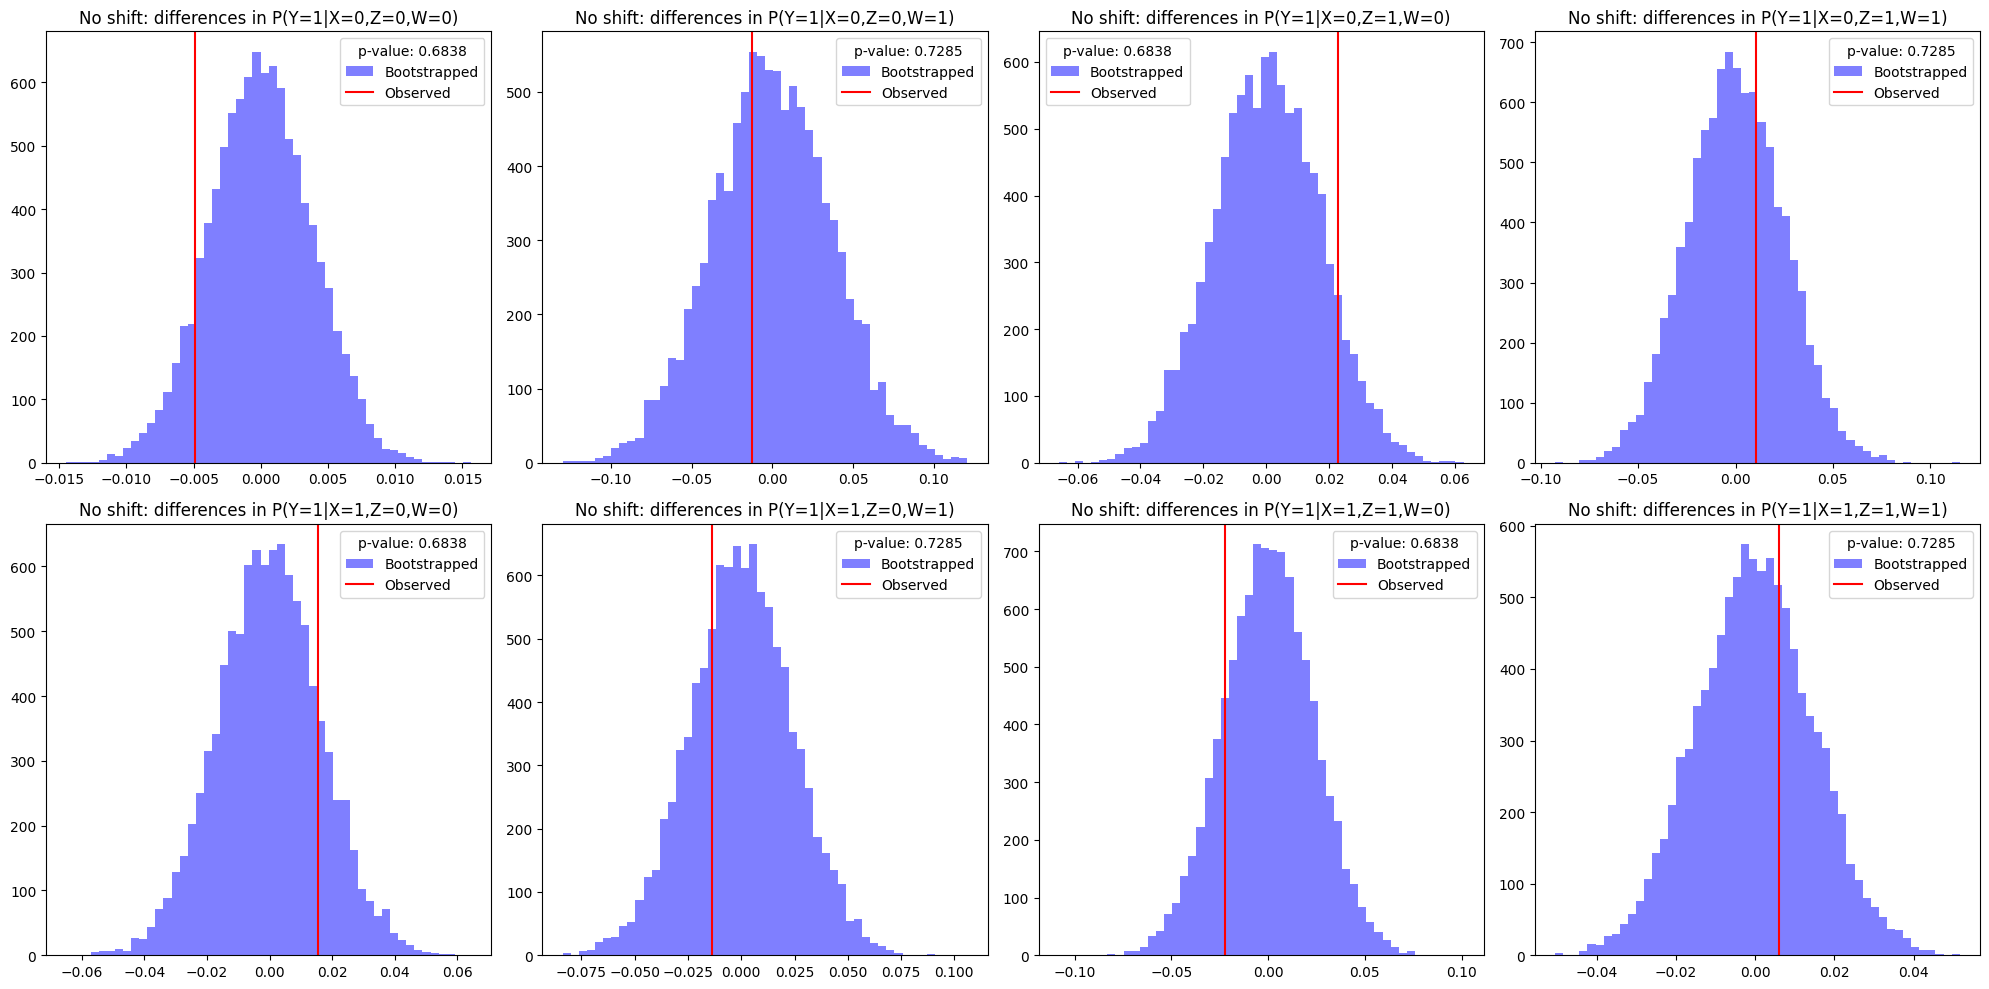

In [27]:
#Histogram of bootstrapped differences for each tested conditional probability

fig, axes = plt.subplots(2,4, figsize=(20,10))
#Sample 1 vs Sample 2
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_2[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_2['Difference'][i], color='red', label='Observed')
    ax.set_title(f"No shift: differences in {index[i]}")
    #Add p-value
    ax.legend(title=f'p-value: {np.round(bh_p_values_sample_1_sample_2[i],4)}')
plt.tight_layout()
plt.show()

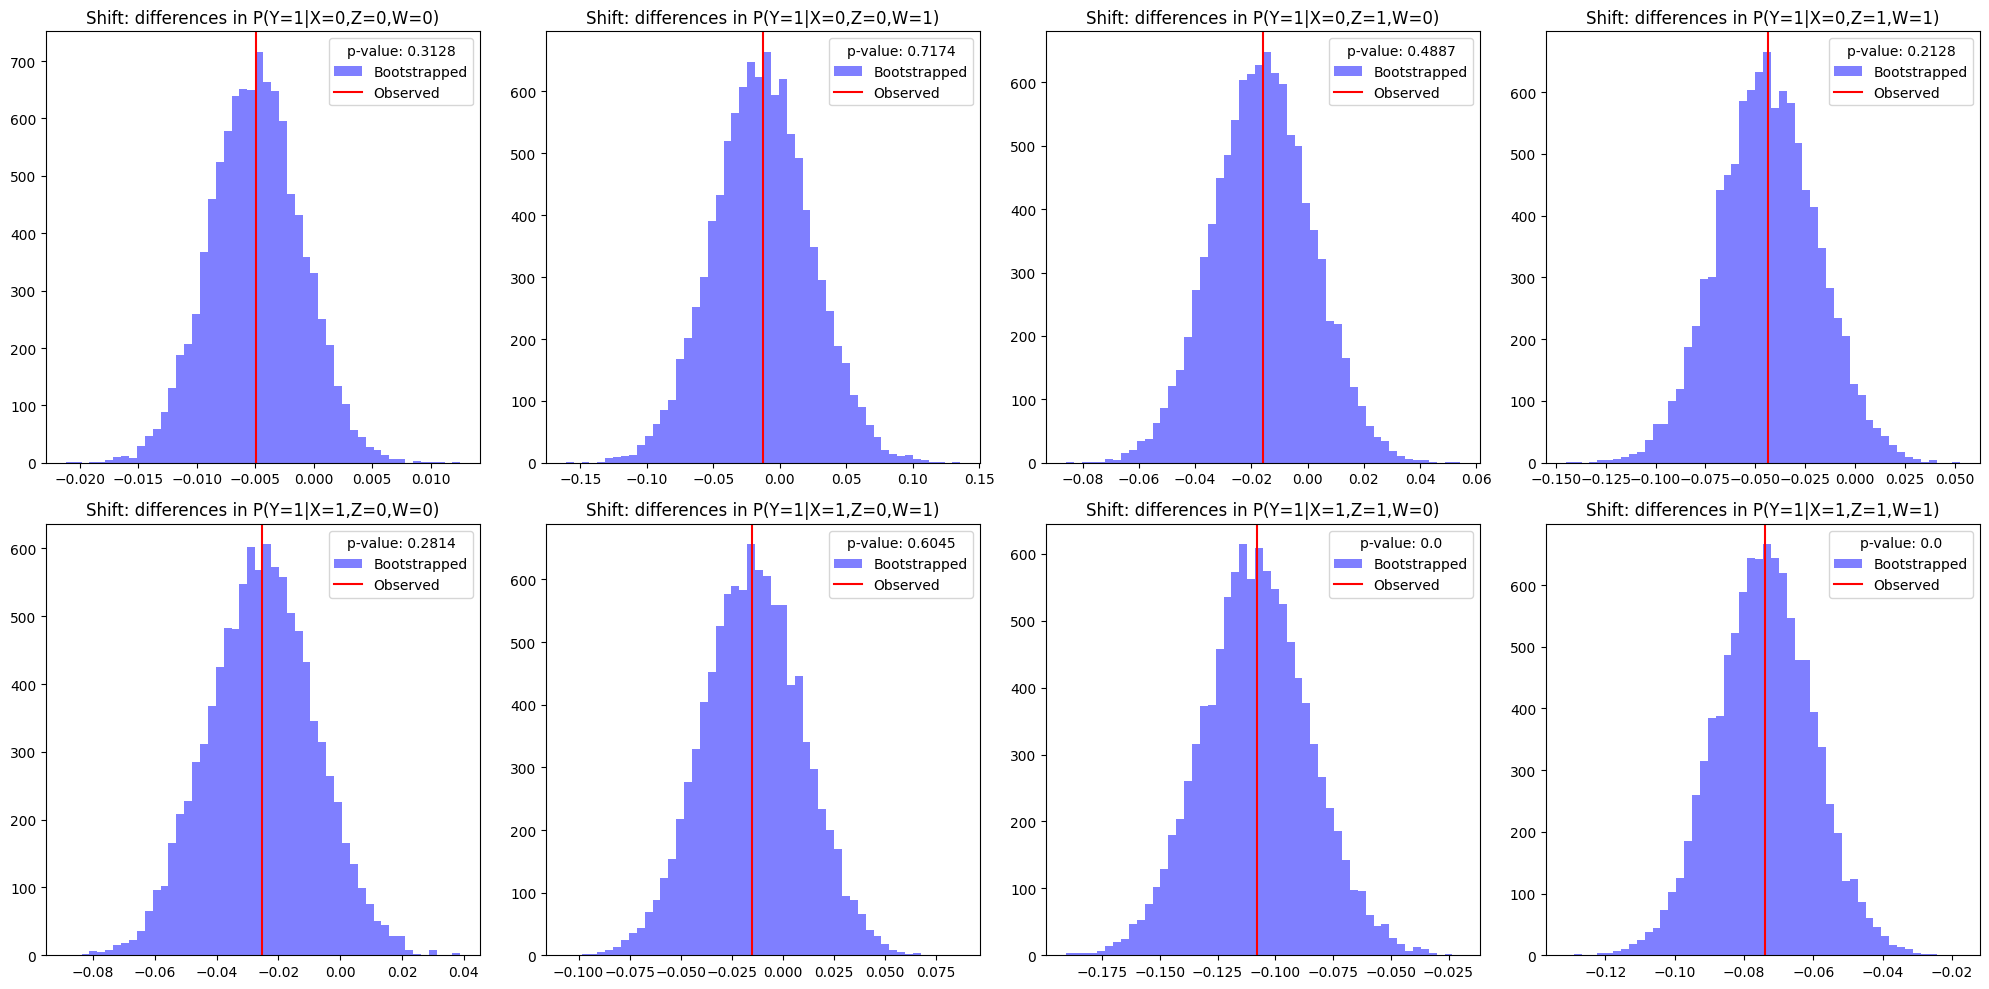

In [29]:
#Histogram of bootstrapped differences for each tested conditional probability
fig, axes = plt.subplots(2,4 , figsize=(20,10))
#Sample 1 vs Sample 3
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_3['Difference'][i], color='red', label='Observed')
    ax.set_title(f"Shift: differences in {index[i]}")
    #Add p-value
    ax.legend(title=f'p-value: {np.round(bh_p_values_sample_1_sample_3[i],4)}')
plt.tight_layout()
plt.show()

In [28]:
def bootstrap_test_CI(sample_a,sample_b, B=10000):

    '''
    Function to perform bootstrap test for difference in conditional probabilities of Y=1 given X,Z,W for two samples

    Parameters:

    sample_a: pandas DataFrame containing sample A
    sample_b: pandas DataFrame containing sample B
    B: int, number of bootstrap iterations
    
    Returns:

    bootstrapped_diff: numpy array containing bootstrapped differences in conditional probabilities of Y=1 given X,Z,W between sample_a and sample_b
    p_values: numpy array for the individual hypothesis tests
    '''

    #compute difference in conditionals between sample_a and sample_b
    y_conditional_on_xzw_sample_a = sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_on_xzw_sample_b = sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
    y_conditional_difference_sample_a_sample_b = y_conditional_on_xzw_sample_a['Y'].values - y_conditional_on_xzw_sample_b['Y'].values
    #empty array to store bootstrapped differences (8 x B)
    bootstrapped_diff = np.empty((8,B))
    #empty array to store p-values (8)
    p_values = np.zeros(8)
    #loop through B iterations
    for i in tqdm.tqdm(range(B), desc='Bootstrapping'):       
        #create bootstrap samples
        bootstrap_sample_a = sample_a.sample(n=len(sample_a), replace=True)
        bootstrap_sample_b = sample_b.sample(n=len(sample_b), replace=True)
        #compute difference in conditionals between bootstrap_sample_a and bootstrap_sample_b
        y_conditional_on_xzw_bootstrap_sample_a = bootstrap_sample_a.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_on_xzw_bootstrap_sample_b = bootstrap_sample_b.groupby(['X','Z','W'])['Y'].mean().reset_index()
        y_conditional_difference_bootstrap_sample_a_sample_b = y_conditional_on_xzw_bootstrap_sample_a['Y'].values - y_conditional_on_xzw_bootstrap_sample_b['Y'].values
        #store bootstrapped difference
        bootstrapped_diff[:,i] = y_conditional_difference_bootstrap_sample_a_sample_b

    #compute CIs for each conditional probability: 2*observed difference - bootstrap quantiles
    lower_bound = 2*y_conditional_difference_sample_a_sample_b - np.quantile(bootstrapped_diff,0.975, axis=1)
    upper_bound = 2*y_conditional_difference_sample_a_sample_b - np.quantile(bootstrapped_diff,0.025, axis=1)


    #return differences and p-values
    return bootstrapped_diff, lower_bound, upper_bound

#perform the bootstrap test for sample 1 vs sample 2 and sample 1 vs sample 3
bootstrapped_diff_sample_1_sample_2, lower_bound_sample_1_sample_2, upper_bound_sample_1_sample_2 = bootstrap_test_CI(sample_1, sample_2)
bootstrapped_diff_sample_1_sample_3, lower_bound_sample_1_sample_3, upper_bound_sample_1_sample_3 = bootstrap_test_CI(sample_1, sample_3)

Bootstrapping: 100%|██████████| 10000/10000 [00:47<00:00, 208.57it/s]


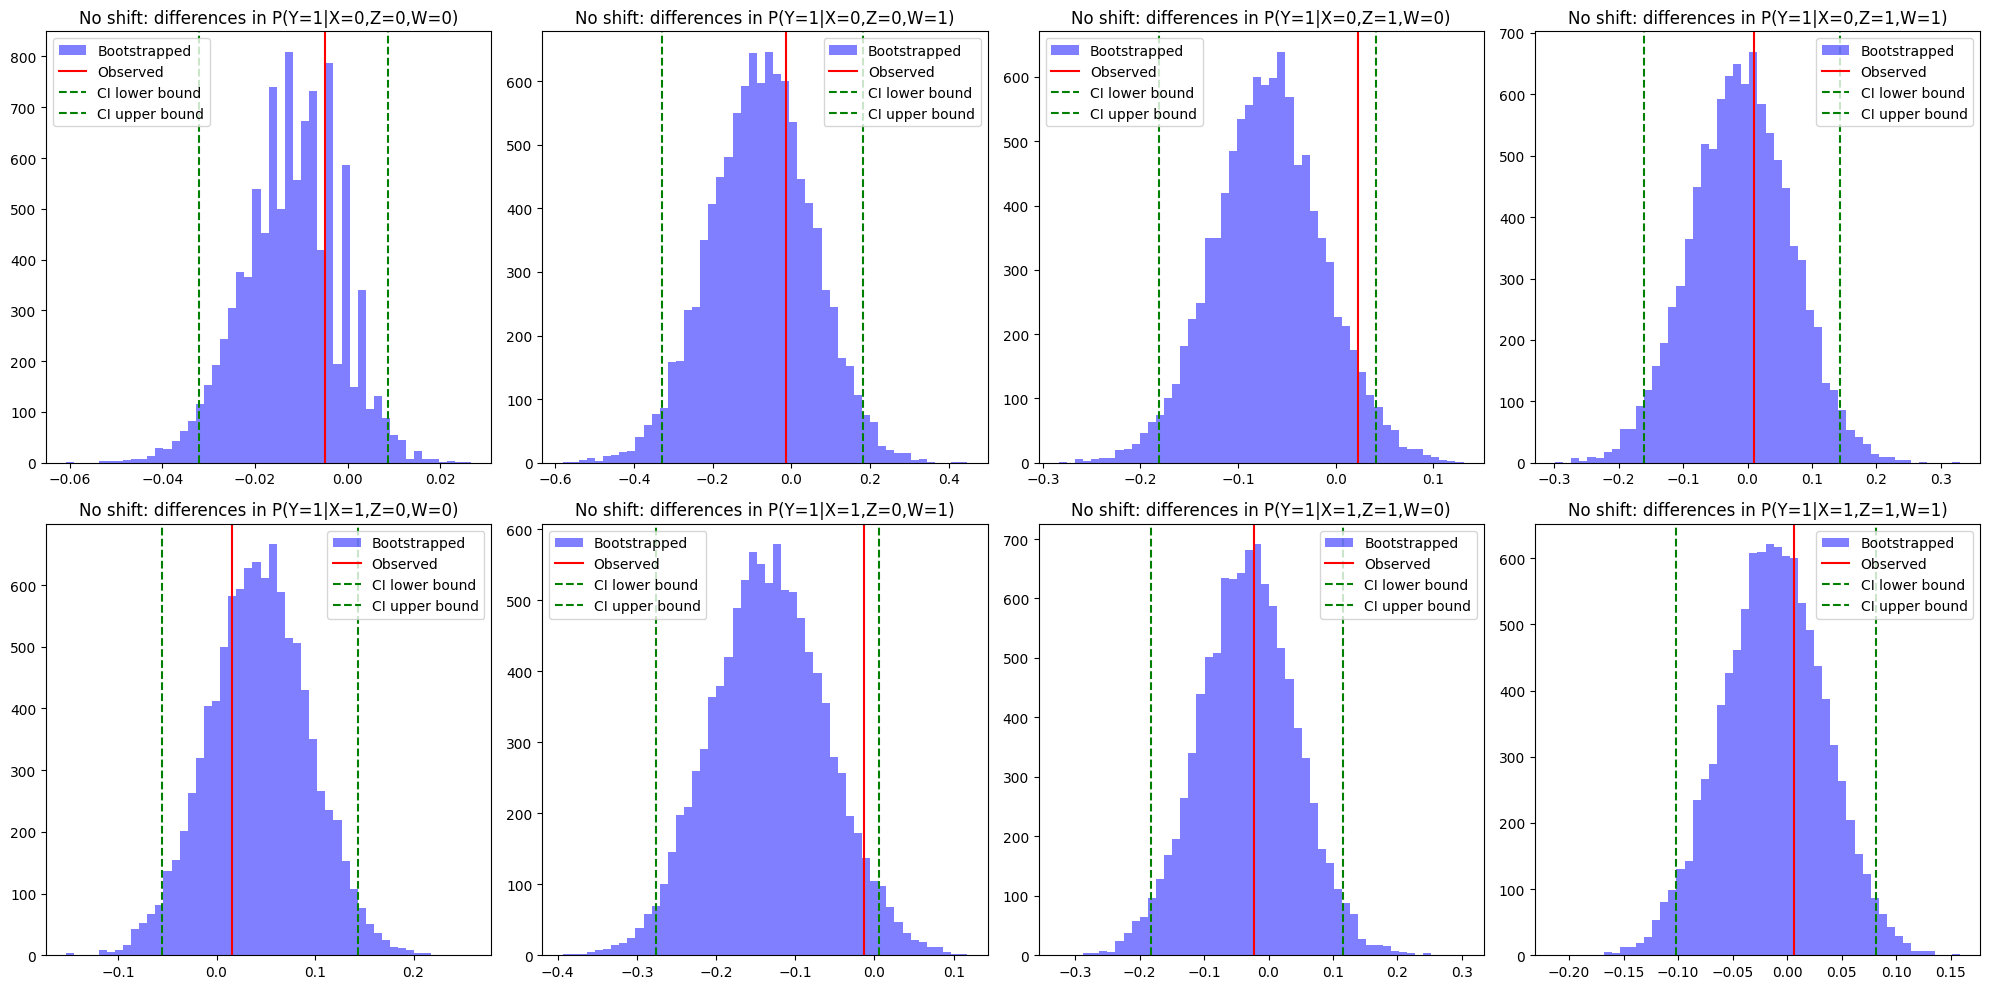

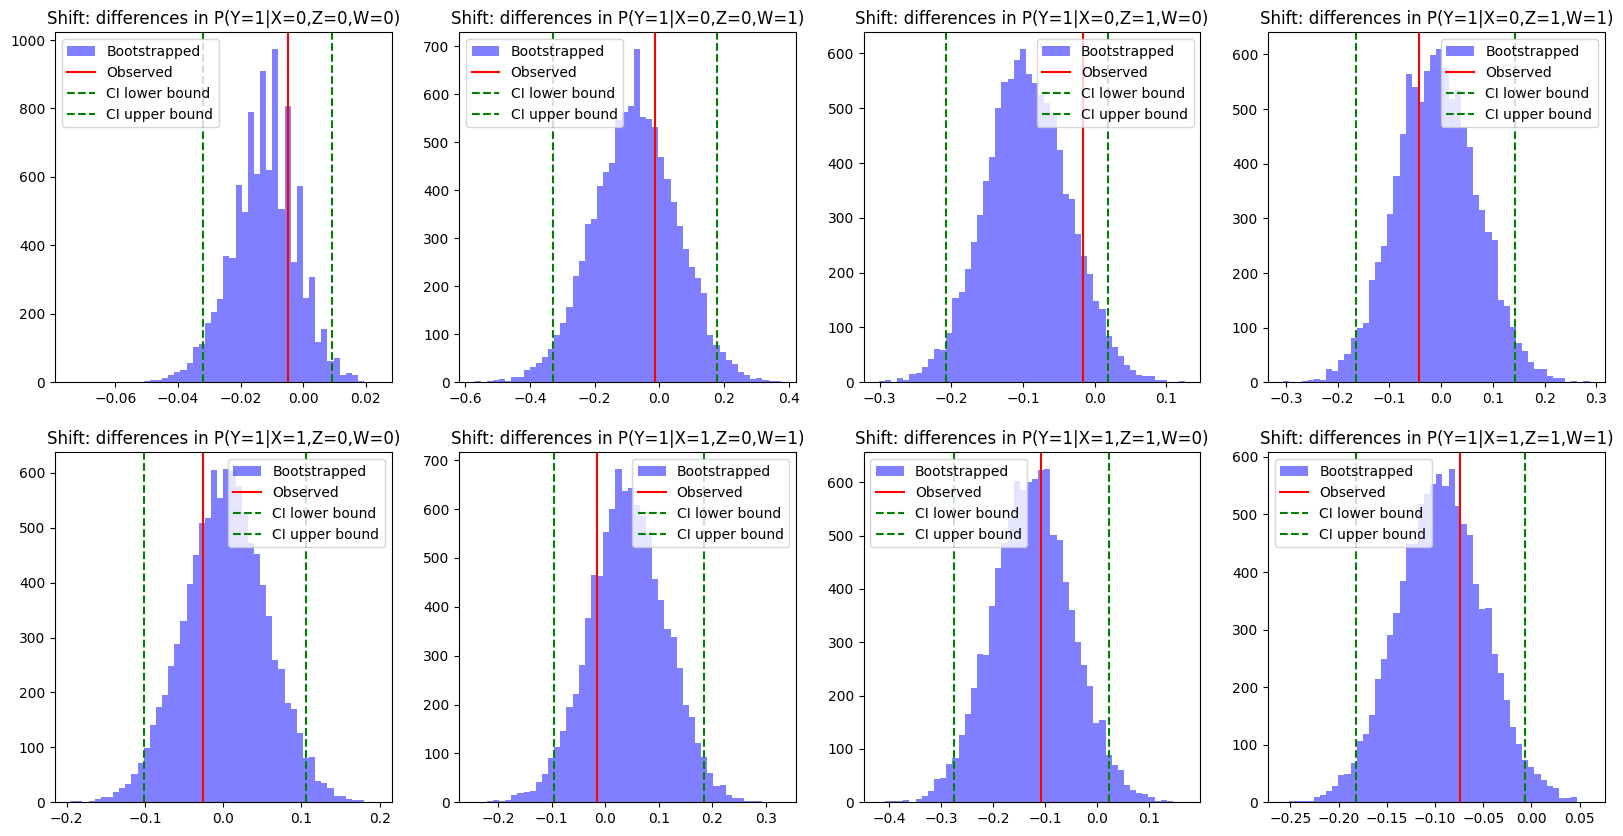

In [23]:
#Plot the CIs for each tested conditional probability
fig, axes = plt.subplots(2,4, figsize=(20,10))
#Sample 1 vs Sample 2
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_2[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_2['Difference'][i], color='red', label='Observed')
    ax.axvline(lower_bound_sample_1_sample_2[i], color='green', linestyle='--', label='CI lower bound')
    ax.axvline(upper_bound_sample_1_sample_2[i], color='green', linestyle='--', label='CI upper bound')
    ax.set_title(f"No shift: differences in {index[i]}")
    #Add p-value
    ax.legend()
plt.tight_layout()
plt.show()

#Plot the CIs for each tested conditional probability
fig, axes = plt.subplots(2,4, figsize=(20,10))
#Sample 1 vs Sample 3
for i in range(8):
    ax = axes[i//4,i%4]
    ax.hist(bootstrapped_diff_sample_1_sample_3[i], bins=50, color='blue', alpha=0.5, label='Bootstrapped')
    ax.axvline(y_conditional_difference_sample_1_sample_3['Difference'][i], color='red', label='Observed')
    ax.axvline(lower_bound_sample_1_sample_3[i], color='green', linestyle='--', label='CI lower bound')
    ax.axvline(upper_bound_sample_1_sample_3[i], color='green', linestyle='--', label='CI upper bound')
    ax.set_title(f"Shift: differences in {index[i]}")
    #Add p-value
    ax.legend()

